# Autoencoders

I've been exploring how useful [autoencoders](https://en.wikipedia.org/wiki/Autoencoder) are and how painfully simple they are to implement in [Keras](https://keras.io/). In this post, my goal is to better understand them myself, so I borrow heavily from [the Keras blog](https://blog.keras.io/building-autoencoders-in-keras.html) on the same topic. So rather than sprinkling references to the Keras blog throughout the post, just assume I borrowed it from [Francois Chollet](https://twitter.com/fchollet). Thanks to Francois for making his code available!

For instance, I thought about drawing a diagram overviewing autoencoders, but it's hard to beat the effective simplicity of this diagram.

![stole from Keras blog](https://blog.keras.io/img/ae/autoencoder_schema.jpg)

So, autoencoders are legit. They perform data compression but not in the JPEG or MPEG way, which make some broad assumptions about images, sound, and video and apply compression based on the assumptions. Instead, autoencoders **learn** (automatically) a lossy compression based on the data examples fed in. So the compression is specific to those examples.

## What's Required

Autoencoders require 3 things:

1. Encoding function
2. Decoding function
3. Loss function describing the amount of information loss between the compressed and decompressed representations of the data examples and the decompressed representation (i.e. a "loss" function).

The encoding/decoding functions are typically (parametric) neural nets and are differentiable with respect to the distance function. The differentiable part enables optimizing the parameters of the encoding/decoding functions to minimize the reconstruction loss.

## What Are They Good For

1. Data Denoising
2. Dimension Reduction
3. Data Visualization (basically the same as 2, but plots)


Dimension reduction is a direct result of the lossy compression of the algorithm. It can help with denoising and **pre-training** before building another ML algorithm. But is the compression good enough to replace JPEG or MPEG? Possibly. Check out [this post](https://hackernoon.com/using-ai-to-super-compress-images-5a948cf09489) based on [a recent paper](https://arxiv.org/abs/1708.00838).

But this post is not about the cutting edge stuff. Instead, we're going to focus on the basics of autoencoders.

# Data Loading and Preprocessing

For this post, I'm going to use the [MNIST data set](http://yann.lecun.com/exdb/mnist/). To get started, let's start with the boilerplate imports.

In [9]:
from IPython.display import Image, SVG
import matplotlib.pyplot as plt

%matplotlib inline

import numpy as np
import keras
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
from keras import regularizers

With that out of the way, let's load the MNIST data set and scale the images to a range between 0 and 1. If you haven't already downloaded the data set, the Keras `load_data` function will download the data directly from S3 on AWS.

In [10]:
# Loads the training and test data sets (ignoring class labels)
(x_train, _), (x_test, _) = mnist.load_data()

# Scales the training and test data to range between 0 and 1.
max_value = float(x_train.max())
x_train = x_train.astype('float32') / max_value
x_test = x_test.astype('float32') / max_value

The data set consists 3D arrays with 60K training and 10K test images. The images have a resolution of 28 x 28 (pixels).

In [11]:
x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

To work with the images as vectors, let's reshape the 3D arrays as matrices. In doing so, we'll reshape the 28 x 28 images into vectors of length 784

In [12]:
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

(x_train.shape, x_test.shape)

((60000, 784), (10000, 784))

***

# Simple Autoencoder

Let's start with a simple autoencoder for illustration. The encoder and decoder functions are each fully-connected neural layers. The encoder function uses a [ReLU activation function](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)), while the decoder function uses a [sigmoid activation function](https://en.wikipedia.org/wiki/Activation_function#Comparison_of_activation_functions).

So what are the encoder and the decoder layers doing?

* The encoder layer "encodes" the input image as a compressed representation in a reduced dimension. The compressed image typically looks garbled, nothing like the original image.
* The decoder layer "decodes" the encoded image back to the original dimension. The decoded image is a [lossy reconstruction](https://en.wikipedia.org/wiki/Lossy_compression) of the original image.

In our example, the compressed image has a dimension of 32. The encoder model reduces the dimension from the original 784-dimensional vector to the encoded 32-dimensional vector. The decoder model restores the dimension from the encoded 32-dimensional representation back to the original 784-dimensional vector.

The compression factor is the ratio of the input dimension to the encoded dimension. In our case, the factor is `24.5 = 784 / 32`.

The `autoencoder` model maps an input image to its reconstructed image.

In [13]:
# input dimension = 784
input_dim = x_train.shape[1]
encoding_dim = 32

compression_factor = float(input_dim) / encoding_dim
print("Compression factor: %s" % compression_factor)

autoencoder = Sequential()
autoencoder.add(
    Dense(encoding_dim, input_shape=(input_dim,), activation='relu')
)
autoencoder.add(
    Dense(input_dim, activation='sigmoid')
)

autoencoder.summary()

Compression factor: 24.5
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 32)                25120     
                                                                 
 dense_3 (Dense)             (None, 784)               25872     
                                                                 
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


## Encoder Model

We can extract the encoder model from the first layer of the autoencoder model. The reason we want to extract the encoder model is to examine what an encoded image looks like.

In [14]:
input_img = Input(shape=(input_dim,))
encoder_layer = autoencoder.layers[0]
encoder = Model(input_img, encoder_layer(input_img))

encoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense_2 (Dense)             (None, 32)                25120     
                                                                 
Total params: 25,120
Trainable params: 25,120
Non-trainable params: 0
_________________________________________________________________


Okay, now we're ready to train our first autoencoder. We'll iterate on the training data in batches of 256 in 50 epochs. Let's also use [the Adam optimizer](https://arxiv.org/abs/1412.6980) and per-pixel binary [crossentropy](https://en.wikipedia.org/wiki/Cross_entropy) loss. The purpose of the loss function is to reconstruct an image similar to the input image.

I want to call out something that may look like a typo or may not be obvious at first glance. Notice the repeat of `x_train` in `autoencoder.fit(x_train, x_train, ...)`. This implies that `x_train` is both the input and output, which is exactly what we want for image reconstruction.

I'm running this code on a laptop, so you'll notice the training times are a bit slow (no GPU).

In [15]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/50


2023-10-05 09:55:13.895883: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 188160000 exceeds 10% of free system memory.
2023-10-05 09:55:14.020742: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 188160000 exceeds 10% of free system memory.


235/235 [==============================] - 3s 9ms/step - loss: 0.2767 - val_loss: 0.1907
Epoch 2/50
235/235 [==============================] - 2s 9ms/step - loss: 0.1708 - val_loss: 0.1527
Epoch 3/50
235/235 [==============================] - 2s 9ms/step - loss: 0.1436 - val_loss: 0.1335
Epoch 4/50
235/235 [==============================] - 2s 9ms/step - loss: 0.1284 - val_loss: 0.1212
Epoch 5/50
235/235 [==============================] - 2s 9ms/step - loss: 0.1182 - val_loss: 0.1130
Epoch 6/50
235/235 [==============================] - 2s 9ms/step - loss: 0.1112 - val_loss: 0.1070
Epoch 7/50
235/235 [==============================] - 2s 9ms/step - loss: 0.1060 - val_loss: 0.1026
Epoch 8/50
235/235 [==============================] - 2s 9ms/step - loss: 0.1021 - val_loss: 0.0993
Epoch 9/50
235/235 [==============================] - 2s 9ms/step - loss: 0.0993 - val_loss: 0.0969
Epoch 10/50
235/235 [==============================] - 2s 9ms/step - loss: 0.0974 - val_loss: 0.0954
Epoch 11/5

We've successfully trained our first autoencoder. With a mere 50,992 parameters, our autoencoder model can compress an MNIST digit down to 32 floating-point digits. Not that impressive, but it works.

To check out the encoded images and the reconstructed image quality, we randomly sample 10 test images. I really like how the encoded images look. Do they make sense? No. Are they eye candy though? Most definitely.

However, the reconstructed images are quite lossy. You can see the digits clearly, but notice the loss in image quality.

## Plot the compressed images

313/313 [==============================] - 0s 1ms/step


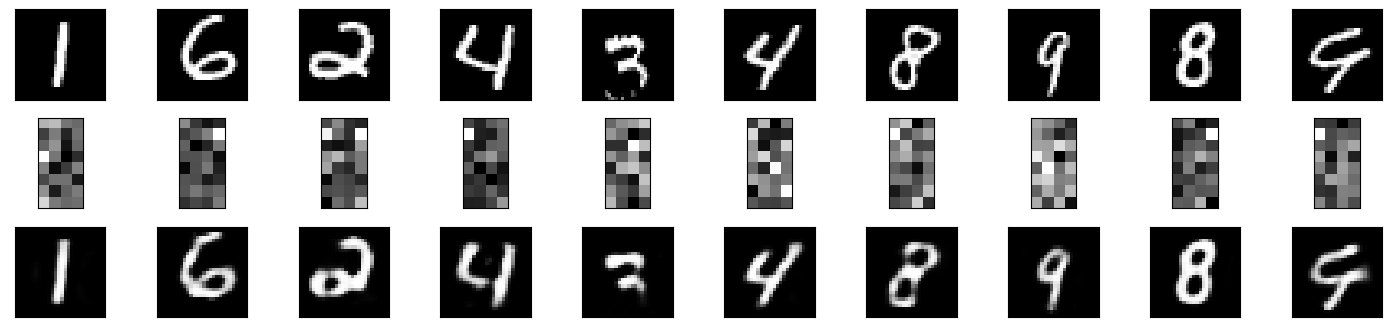

In [16]:
num_images = 10
np.random.seed(42)
random_test_images = np.random.randint(x_test.shape[0], size=num_images)

encoded_imgs = encoder.predict(x_test)
decoded_imgs = autoencoder.predict(x_test)

plt.figure(figsize=(18, 4))

for i, image_idx in enumerate(random_test_images):
    # plot original image
    ax = plt.subplot(3, num_images, i + 1)
    plt.imshow(x_test[image_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # plot encoded image
    ax = plt.subplot(3, num_images, num_images + i + 1)
    plt.imshow(encoded_imgs[image_idx].reshape(8, 4))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # plot reconstructed image
    ax = plt.subplot(3, num_images, 2*num_images + i + 1)
    plt.imshow(decoded_imgs[image_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()